# Stock Protection Simulation
### Calendar Put Spread - Merton Jump-Diffusion Monte Carlo

**Strategy:**
- **Leg A (long):**  1 put  |  strike = S0 x (1 - loss limit)  |  expiry T1
- **Leg B (short):** 2 puts |  zero-cost strike (auto-solved)   |  expiry T2 > T1

**How to use:**
1. Edit the parameters in **Cell 2 (Configuration)**
2. Re-run **Cell 2** to check the variance budget
3. Re-run **Cell 3** to run the simulation and update the charts

P&L is evaluated at two horizons:
- **T1** -- position unwound mark-to-market (short puts still have time value)
- **T2** -- held to expiry (short puts settle at intrinsic value only)


In [211]:
# Reload all local modules so any .py edits are picked up without restarting
# the kernel.  Works on all Python/IPython versions.
import importlib
import stock_simulator, gbm_simulator, option_pricer, pnl_engine, BlackScholes
for _m in [BlackScholes, option_pricer, stock_simulator, gbm_simulator, pnl_engine]:
    importlib.reload(_m)

import sys, os, warnings
sys.path.insert(0, os.getcwd())
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from stock_simulator import simulate          # Merton jump-diffusion (kept)
from gbm_simulator   import simulate_gbm     # simple GBM (used for paths)
from option_pricer   import solve_zero_cost_strike
from pnl_engine      import compute_pnl
from BlackScholes    import BlackScholesCalculator

%matplotlib inline
plt.rcParams.update({'figure.dpi': 110, 'font.size': 9})
print("Modules loaded OK")

Modules loaded OK


In [217]:
# -----------------------------------------------------------------------------
# CONFIGURATION  --  edit values here, then re-run this cell and Cell 3
# -----------------------------------------------------------------------------
S0 = 123.0   

CFG = dict(
    # -- Market ----------------------------------------------------------------
    sigma_total      = 0.9,   # total observed historical vol  (0.20 = 20 %)
    mu               = 0.1,   # real-world annual drift        (0.08 =  8 %)
    r                = 0.04,   # risk-free rate
    q                = 0.00,   # continuous dividend yield

    # -- Protection structure --------------------------------------------------
    loss_pct         = (123-100)/123,   # maximum acceptable loss        (0.10 = 10 %)
    T1               = 1.3,   # long  put expiry  (years)
    T2               = 2.6,   # short put expiry  (years) -- must be > T1

    # -- Simulation ------------------------------------------------------------
    n_sims           = 5000,   # Monte Carlo paths  (increase for smoother results)
    n_steps_per_year = 52,     # time steps per year (52 = weekly)
    n_plot           = 60,     # individual paths shown in the fan chart
    seed             = 42,     # RNG seed (change for a different random draw)

)


# -----------------------------------------------------------------------------
# RUN SIMULATION  --  re-run this cell after changing CFG
# -----------------------------------------------------------------------------


assert CFG['T2'] > CFG['T1'], f"T2 ({CFG['T2']}) must be > T1 ({CFG['T1']})"

# -- Step 1: GBM paths  (uses sigma_total directly, no jump decomposition) -----
# stock_simulator.simulate (Merton) is still importable for reference.
sim = simulate_gbm({**CFG, 'S0': S0, 'T': CFG['T2']})

# -- Step 2: solve zero-cost strike  (BS pricing vol = sigma_total) ------------
zc = solve_zero_cost_strike({**CFG, 'S0': S0, 'sigma': CFG['sigma_total']})

# -- Step 3: compute P&L at T1 (MtM) and T2 (expiry) --------------------------
pnl = compute_pnl(sim, zc, {**CFG, 'S0': S0, 'sigma': CFG['sigma_total']})

S_T1, \
S_T2,\
unhedged_PL_T1,\
unhedged_PL_T2,\
hedged_PL_T1,\
hedged_PL_T2,\
prob_loss_unhedged_T1,\
prob_loss_unhedged_T2,\
prob_loss_hedged_T1, \
prob_loss_hedged_T2,\
prob_short_itm_T2 \
= pnl

zc.K_long , zc.K_short,zc.long_put_prem, zc.short_put_prem, zc.long_put_prem-2*zc.short_put_prem

(100.0,
 55.46470080853627,
 29.923223300111342,
 16.121611649785976,
 -2.3199999994606095)

In [218]:

np.mean(np.maximum(zc.K_long - S_T1, 0.0))*np.exp(-CFG['T1']*CFG['r'])


np.float64(27.995989377674256)

In [219]:
np.mean(np.maximum(zc.K_short - S_T2, 0.0))*np.exp(-CFG['T2']*CFG['r'])

np.float64(14.797082008627703)

(81.0, 44.72823298386749)

(20.589058734189738, 10.294529392486991)

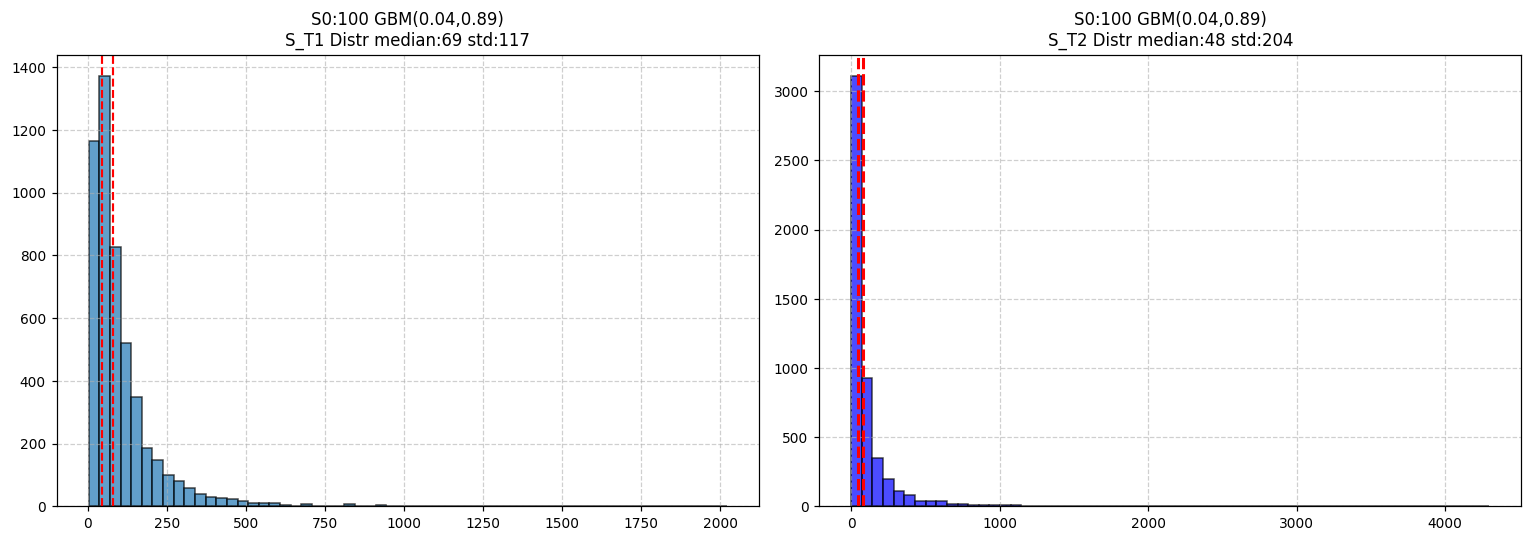

In [189]:

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot on the first axis (left)
ax1.hist(S_T1, bins=60, edgecolor='black', alpha=0.7)
ax1.grid(True, linestyle='--', alpha=0.6)
# Note the double quotes used for "mu" and "sigma_total" inside the f-string
ax1.set_title(f'S0:{S0:.0f} GBM({CFG["mu"]},{CFG["sigma_total"]})\nS_T1 Distr median:{np.percentile(S_T1, 50):.0f} std:{S_T1.std():.0f}')
ax1.axvline(zc.K_long, color='red',    ls='--', lw=1.4, label=f'K_short={zc.K_long:.0f}')
ax1.axvline(zc.K_short, color='red',   ls='--', lw=1.4, label=f'K_short={zc.K_short:.0f}')

# Plot on the second axis (right)
ax2.hist(S_T2, bins=60, edgecolor='black', alpha=0.7, color='blue')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_title(f'S0:{S0:.0f} GBM({CFG["mu"]},{CFG["sigma_total"]})\nS_T2 Distr median:{np.percentile(S_T2, 50):.0f} std:{S_T2.std():.0f}')
ax2.axvline(zc.K_long,  color='red',    ls='--', lw=2, label=f'K_short={zc.K_long:.0f}')
ax2.axvline(zc.K_short, color='red',   ls='--', lw=2, label=f'K_short={zc.K_short:.0f}')

plt.tight_layout()
plt.show()



In [187]:
np.mean(S_T2 - S0 < - CFG["loss_pct"] * S0), CFG["loss_pct"] *S0

(np.float64(0.657), 19.0)

In [179]:

prob_loss_unhedged_T2,\
prob_loss_hedged_T2


(0.657, 0.587)

In [192]:
zc.short_put_prem, zc.K_short

(10.294529392486991, 44.72823298386749)

In [214]:
np.mean(np.maximum(zc.K_short - S_T2, 0.0))*np.exp(-CFG['T2']*CFG['r'])

np.float64(16.527763708938387)

In [196]:
np.mean(np.maximum(zc.K_long - S_T1, 0.0))*np.exp(-CFG['T1']*CFG['r'])

np.float64(20.669587401692183)

  STRATEGY  (S0=100   loss limit=10%)
----------------------------------------------------------------
  sigma_total  (BS pricing)   = 20.0%
  sigma_diff   (MC diffusion) = 9.35%   [jump var = 78.1% of budget]
----------------------------------------------------------------
  Leg A  LONG  put   K= 90.00  T=1.00y  prem=2.3101
  Leg B  SHORT put   K= 77.31  T=2.00y  prem=1.1550  x2
  Net premium (target=0)   : +5.87e-11
----------------------------------------------------------------
  Short put ITM @ T2  (MC) :   9.3%
  Protection prob @ T1     :  76.2%   (unwind MtM at T1)
  Protection prob @ T2     :  81.9%   (hold to T2 expiry)
----------------------------------------------------------------
  Metric                Unhedged   Hedged T1   Hedged T2
----------------------------------------------------------------
  Mean P&L                 +8.32%       +8.22%      +17.46%
  Std                     +22.03%      +21.73%      +35.66%
  p5                      -23.72%      -19.39%      -34

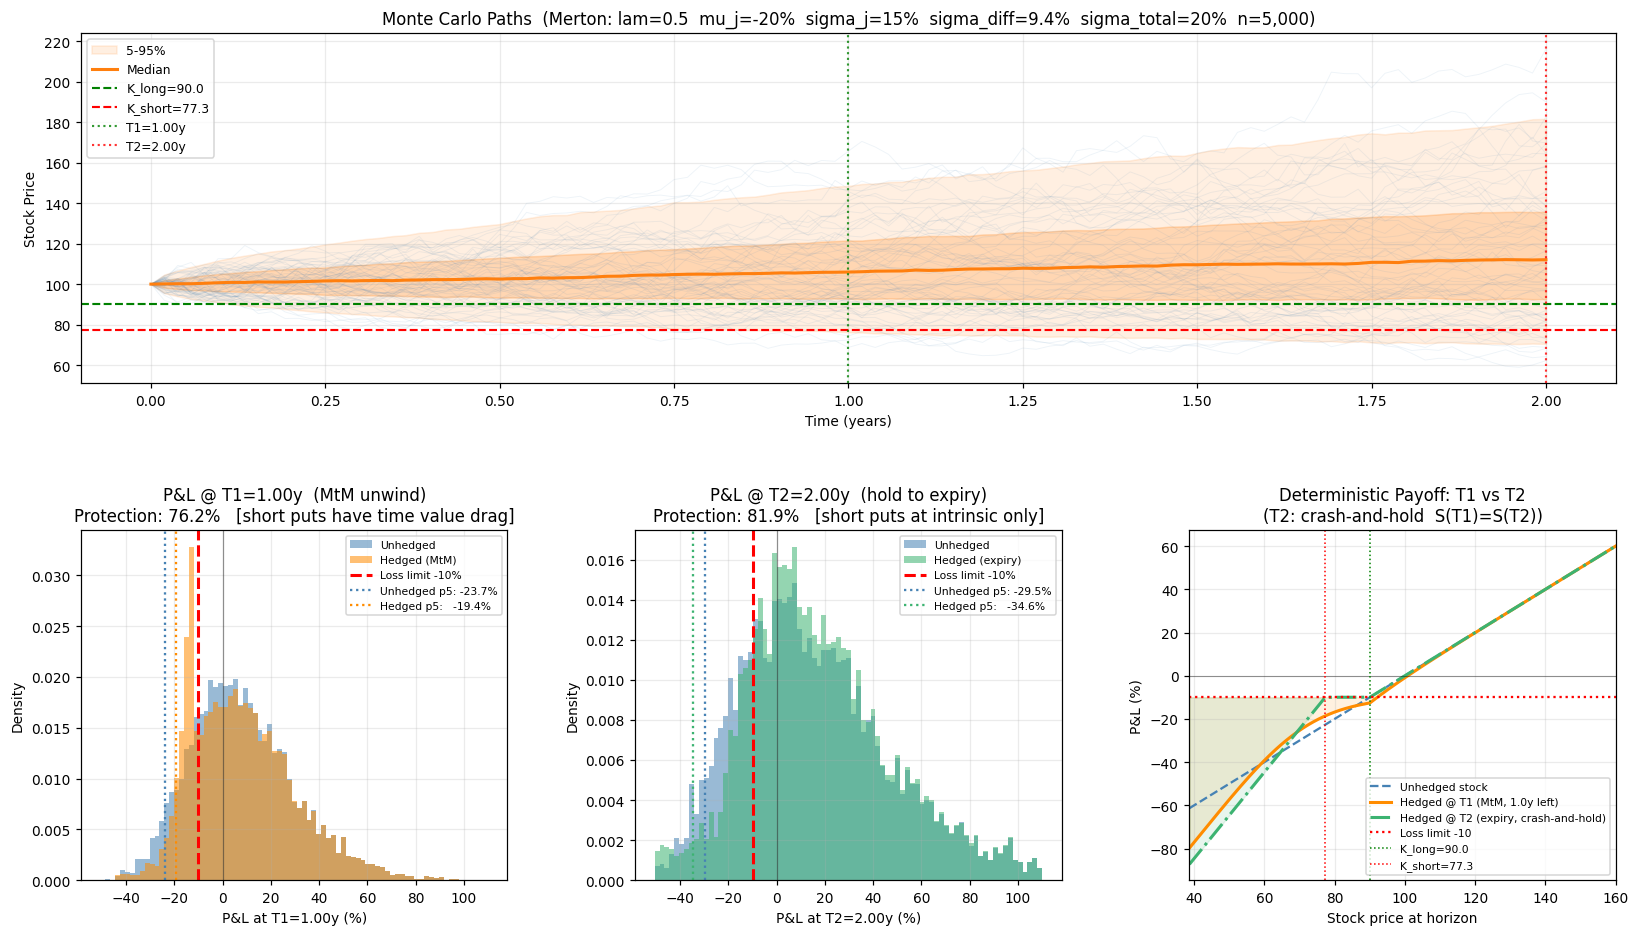

In [ ]:


# -- Summary table -------------------------------------------------------------

sep = '=' * 64
mid = '-' * 64

print(sep)
print(f"  STRATEGY  (S0={S0:.0f}   loss limit={CFG['loss_pct']*100:.0f}%)")
print(mid)
print(f"  sigma_total  (BS pricing)   = {CFG['sigma_total']*100:.1f}%")
print(f"  sigma_diff   (MC diffusion) = {sigma_diff*100:.2f}%   "
      f"[jump var = {jump_pct:.1f}% of budget]")
print(mid)
print(f"  Leg A  LONG  put   K={zc.K_long:6.2f}  T={CFG['T1']:.2f}y  prem={zc.long_put_prem:.4f}")
print(f"  Leg B  SHORT put   K={zc.K_short:6.2f}  T={CFG['T2']:.2f}y  prem={zc.short_put_prem:.4f}  x2")
print(f"  Net premium (target=0)   : {zc.net_premium:+.2e}")
print(mid)
print(f"  Short put ITM @ T2  (MC) : {s['prob_short_itm']:5.1f}%")
print(f"  Protection prob @ T1     : {s['prob_protected']:5.1f}%   (unwind MtM at T1)")
print(f"  Protection prob @ T2     : {s['prob_protected_T2']:5.1f}%   (hold to T2 expiry)")
print(mid)
print(f"  {'Metric':<18}  {'Unhedged':>10}  {'Hedged T1':>10}  {'Hedged T2':>10}")
print(mid)
for label, uk, hk, h2k in [
    ('Mean P&L',  'unhedged_mean',   'hedged_mean',   'hedged_T2_mean'),
    ('Std',       'unhedged_std',    'hedged_std',    'hedged_T2_std'),
    ('p5',        'unhedged_p5',     'hedged_p5',     'hedged_T2_p5'),
    ('p25',       'unhedged_p25',    'hedged_p25',    'hedged_T2_p25'),
    ('Median',    'unhedged_median', 'hedged_median', 'hedged_T2_median'),
    ('p75',       'unhedged_p75',    'hedged_p75',    'hedged_T2_p75'),
    ('p95',       'unhedged_p95',    'hedged_p95',    'hedged_T2_p95'),
]:
    print(f"  {label:<18}  {s[uk]:>+10.2f}%  {s[hk]:>+10.2f}%  {s[h2k]:>+10.2f}%")
print(sep)

# -- Delta / ITM probability sanity check -------------------------------------
# The BS delta of a put equals -N(-d1).  The risk-neutral probability that the
# put expires ITM is N(-d2).  For a GBM simulation these two bracket the true
# probability:
#   * Under risk-neutral drift (mu = r): MC frac(S_T < K) --> N(-d2)
#   * |delta| = N(-d1) >= N(-d2)  always  (d1 > d2 by sigma*sqrt(T))
#   * With real-world drift mu > r: MC frac shifts upward vs risk-neutral.
#
# These numbers validate that the GBM simulator produces the right distribution.

_r   = CFG['r']
_q   = CFG['q']
_sig = CFG['sigma_total']
_T1  = CFG['T1']
_T2  = CFG['T2']

# Black-Scholes calculators for the two legs
_bsc_long  = BlackScholesCalculator(S0, zc.K_long,  _T1, _r, _sig, _q)
_bsc_short = BlackScholesCalculator(S0, zc.K_short, _T2, _r, _sig, _q)

# |delta| = N(-d1)  and  prob_ITM_rn = N(-d2)
_delta_long_abs   = abs(_bsc_long.delta('put'))          # N(-d1) long put
_prob_rn_long     = norm.cdf(-_bsc_long.d2)             # N(-d2) long put
_delta_short_abs  = abs(_bsc_short.delta('put'))         # N(-d1) short put
_prob_rn_short    = norm.cdf(-_bsc_short.d2)            # N(-d2) short put

# MC probabilities under real-world drift (mu from CFG)
_mc_long_itm  = float(np.mean(sim.price_at(_T1) < zc.K_long))
_mc_short_itm = float(np.mean(sim.price_at(_T2) < zc.K_short))

# Quick risk-neutral validation: re-run a tiny GBM with mu = r
_sim_rn = simulate_gbm({**CFG, 'S0': S0, 'T': _T2, 'mu': _r, 'n_sims': 20000})
_mc_rn_long  = float(np.mean(_sim_rn.price_at(_T1) < zc.K_long))
_mc_rn_short = float(np.mean(_sim_rn.price_at(_T2) < zc.K_short))

print()
print("  DELTA / ITM-PROBABILITY SANITY CHECK  (GBM, sigma_total throughout)")
print(mid)
print(f"  {'':32}  {'Long put':>10}  {'Short put':>10}")
print(f"  {'Strike / Expiry':32}  {'K='+f'{zc.K_long:.1f}'+' T='+f'{_T1:.1f}y':>10}  "
      f"{'K='+f'{zc.K_short:.1f}'+' T='+f'{_T2:.1f}y':>10}")
print(mid)
print(f"  |delta| = N(-d1)   [BS hedge ratio]  "
      f"{_delta_long_abs*100:>10.1f}%  {_delta_short_abs*100:>10.1f}%")
print(f"  N(-d2)  = RN prob ITM  [exact]       "
      f"{_prob_rn_long*100:>10.1f}%  {_prob_rn_short*100:>10.1f}%")
print(f"  MC prob ITM  (mu=r, RN)  [sim check] "
      f"{_mc_rn_long*100:>10.1f}%  {_mc_rn_short*100:>10.1f}%")
print(f"  MC prob ITM  (mu={CFG['mu']*100:.0f}%, real-world)       "
      f"{_mc_long_itm*100:>10.1f}%  {_mc_short_itm*100:>10.1f}%")
print(mid)
print("  Interpretation:")
print("    N(-d2) == MC(RN) confirms GBM paths are correctly calibrated.")
print("    N(-d1) > N(-d2) by the vol-time factor sigma*sqrt(T).")
print(f"    d1-d2 = sigma*sqrt(T) = {_sig*np.sqrt(_T1)*100:.1f}% (long)  "
      f"{_sig*np.sqrt(_T2)*100:.1f}% (short)")
print("    Real-world MC > RN MC because drift mu > r pushes stock up,")
print("    making ITM (S < K) less likely than under risk-neutral.")
print(sep)

# -- Conditional probability decomposition ------------------------------------
# Decomposes  P(hedged loss > threshold at T2)  into four sub-cases:
#
#   Case 1  S(T1) >= K_long  --> long put expired worthless
#     1a: gap risk only  (K_short <= S(T2) < K_long)  short put OTM
#     1b: gap risk + short put ITM  (S(T2) < K_short)
#
#   Case 2  S(T1) < K_long  --> long put paid off K_long - S(T1)
#     2a: continued decline, short put OTM  (K_short <= S(T2) < S(T1))
#     2b: continued decline + short put ITM (S(T2) < K_short)
#
# Key insight: In Case 1 the long put gives NOTHING.  Any path where the
# stock is above K_long at T1 but below K_long at T2 (i.e. K_short <= S(T2)
# < K_long) generates a loss > threshold with no short-put offset.  This
# "gap risk" is why P(loss > threshold) >> P(short put ITM).

_loss_mask  = pnl.hedged_pct_T2 < pnl.loss_threshold   # excess loss at T2
_c1         = pnl.S_T1 >= zc.K_long                    # Case 1: long put worthless
_c2         = ~_c1                                      # Case 2: long put paid off
_short_itm2 = pnl.S_T2 < zc.K_short                    # short put ITM at T2

_m1a = _c1 & ~_short_itm2 & _loss_mask   # 1a: gap risk, short put OTM
_m1b = _c1 &  _short_itm2 & _loss_mask   # 1b: gap risk + short put ITM
_m2a = _c2 & ~_short_itm2 & _loss_mask   # 2a: continued decline, short put OTM
_m2b = _c2 &  _short_itm2 & _loss_mask   # 2b: continued decline + short put ITM

_p_loss = _loss_mask.mean() * 100
_p1a = _m1a.mean() * 100; _p1b = _m1b.mean() * 100
_p2a = _m2a.mean() * 100; _p2b = _m2b.mean() * 100
_p_c1 = _c1.mean() * 100; _p_c2 = _c2.mean() * 100

_cp1a = _m1a.sum() / max(_c1.sum(), 1) * 100
_cp1b = _m1b.sum() / max(_c1.sum(), 1) * 100
_cp2a = _m2a.sum() / max(_c2.sum(), 1) * 100
_cp2b = _m2b.sum() / max(_c2.sum(), 1) * 100

print()
print("  LOSS DECOMPOSITION @ T2  (P(hedged loss > threshold))")
print(mid)
print(f"  Direct MC estimate : {_p_loss:.1f}%   (= 100 - prob_protected_T2)")
print(mid)
print(f"  {'Case':<46}  {'P(joint)':>8}  {'P(|case)':>8}")
print(mid)
print(f"  Case 1  S(T1) >= K1={zc.K_long:.1f}  long put worthless  ({_p_c1:.1f}% of paths)")
print(f"    1a  gap risk, short put OTM "
      f"[{zc.K_short:.1f} <= S(T2) < {zc.K_long:.1f}]      {_p1a:>8.1f}%  {_cp1a:>7.1f}%")
print(f"    1b  gap risk + short put ITM "
      f"[S(T2) < {zc.K_short:.1f}]               {_p1b:>8.1f}%  {_cp1b:>7.1f}%")
print(mid)
print(f"  Case 2  S(T1) <  K1={zc.K_long:.1f}  long put paid off   ({_p_c2:.1f}% of paths)")
print(f"    2a  continued decline, short put OTM "
      f"[S(T2) < S(T1)]          {_p2a:>8.1f}%  {_cp2a:>7.1f}%")
print(f"    2b  continued decline + short put ITM "
      f"[S(T2) < {zc.K_short:.1f}]      {_p2b:>8.1f}%  {_cp2b:>7.1f}%")
print(mid)
print(f"  Sum 1a+1b+2a+2b    : {_p1a+_p1b+_p2a+_p2b:.1f}%  (check vs direct MC above)")
print(sep)

# -- Figure --------------------------------------------------------------------
#   Row 0 : fan chart  (full width)
#   Row 1 : P&L @ T1  |  P&L @ T2  |  Deterministic payoff curves
fig = plt.figure(figsize=(18, 10))
gs  = gridspec.GridSpec(2, 3, figure=fig, hspace=0.42, wspace=0.30)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

paths = sim.paths
tg    = sim.time_grid
K_l   = zc.K_long
K_s   = zc.K_short
lt    = pnl.loss_threshold

# - Fan chart ------------------------------------------------------------------
n_plot = min(CFG['n_plot'], paths.shape[0])
idx    = np.random.default_rng(0).choice(paths.shape[0], n_plot, replace=False)
for i in idx:
    ax1.plot(tg, paths[i], color='steelblue', alpha=0.09, lw=0.6)
for (plo, phi), alpha in [((5, 95), 0.12), ((25, 75), 0.22)]:
    ax1.fill_between(tg,
                     np.percentile(paths, plo, axis=0),
                     np.percentile(paths, phi, axis=0),
                     alpha=alpha, color='tab:orange',
                     label=f'{plo}-{phi}%' if plo == 5 else None)
ax1.plot(tg, np.percentile(paths, 50, axis=0),
         color='tab:orange', lw=2.0, label='Median')
ax1.axhline(K_l, color='green', ls='--', lw=1.4, label=f'K_long={K_l:.1f}')
ax1.axhline(K_s, color='red',   ls='--', lw=1.4, label=f'K_short={K_s:.1f}')
ax1.axvline(CFG['T1'], color='green', ls=':', lw=1.4, alpha=0.8,
            label=f"T1={CFG['T1']:.2f}y")
ax1.axvline(CFG['T2'], color='red',   ls=':', lw=1.4, alpha=0.8,
            label=f"T2={CFG['T2']:.2f}y")
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Stock Price')
ax1.set_title(
    f"Monte Carlo Paths  (Merton: lam={CFG['lam']:.1f}  "
    f"mu_j={CFG['mu_j']*100:.0f}%  sigma_j={CFG['sigma_j']*100:.0f}%  "
    f"sigma_diff={sigma_diff*100:.1f}%  sigma_total={CFG['sigma_total']*100:.0f}%  "
    f"n={CFG['n_sims']:,})")
ax1.legend(fontsize=8, loc='upper left')
ax1.grid(True, alpha=0.25)

# shared x-axis range for both histograms
all_mc = np.concatenate([pnl.unhedged_pct,    pnl.hedged_pct,
                          pnl.unhedged_pct_T2, pnl.hedged_pct_T2])
x_lo = max(float(np.percentile(all_mc,  1)) - 5, -120)
x_hi = min(float(np.percentile(all_mc, 99)) + 5,  120)
bins = np.linspace(x_lo, x_hi, 80)

# - P&L histogram at T1 --------------------------------------------------------
ax2.hist(pnl.unhedged_pct, bins=bins, alpha=0.55, color='steelblue',
         density=True, label='Unhedged')
ax2.hist(pnl.hedged_pct,   bins=bins, alpha=0.55, color='darkorange',
         density=True, label='Hedged (MtM)')
ax2.axvline(lt, color='red', ls='--', lw=2.0,
            label=f'Loss limit {lt:.0f}%')
ax2.axvline(s['unhedged_p5'], color='steelblue',  ls=':', lw=1.5,
            label=f"Unhedged p5: {s['unhedged_p5']:.1f}%")
ax2.axvline(s['hedged_p5'],   color='darkorange', ls=':', lw=1.5,
            label=f"Hedged p5:   {s['hedged_p5']:.1f}%")
ax2.axvline(0, color='black', lw=0.8, alpha=0.4)
ax2.set_xlabel(f"P&L at T1={CFG['T1']:.2f}y (%)")
ax2.set_ylabel('Density')
ax2.set_title(
    f"P&L @ T1={CFG['T1']:.2f}y  (MtM unwind)\n"
    f"Protection: {s['prob_protected']:.1f}%   [short puts have time value drag]")
ax2.legend(fontsize=7)
ax2.grid(True, alpha=0.25)

# - P&L histogram at T2 --------------------------------------------------------
ax3.hist(pnl.unhedged_pct_T2, bins=bins, alpha=0.55, color='steelblue',
         density=True, label='Unhedged')
ax3.hist(pnl.hedged_pct_T2,   bins=bins, alpha=0.55, color='mediumseagreen',
         density=True, label='Hedged (expiry)')
ax3.axvline(lt, color='red', ls='--', lw=2.0,
            label=f'Loss limit {lt:.0f}%')
ax3.axvline(s['unhedged_T2_p5'],  color='steelblue',      ls=':', lw=1.5,
            label=f"Unhedged p5: {s['unhedged_T2_p5']:.1f}%")
ax3.axvline(s['hedged_T2_p5'],    color='mediumseagreen',  ls=':', lw=1.5,
            label=f"Hedged p5:   {s['hedged_T2_p5']:.1f}%")
ax3.axvline(0, color='black', lw=0.8, alpha=0.4)
ax3.set_xlabel(f"P&L at T2={CFG['T2']:.2f}y (%)")
ax3.set_ylabel('Density')
ax3.set_title(
    f"P&L @ T2={CFG['T2']:.2f}y  (hold to expiry)\n"
    f"Protection: {s['prob_protected_T2']:.1f}%   [short puts at intrinsic only]")
ax3.legend(fontsize=7)
ax3.grid(True, alpha=0.25)

# - Deterministic payoff curves ------------------------------------------------
S_rng = np.linspace(max(K_s * 0.50, 30.0), 160.0, 400)
c1    = pnl.payoff_curve(S_rng)
c2    = pnl.payoff_curve_T2(S_rng)
ax4.plot(S_rng, c1['unhedged'], color='steelblue',      ls='--', lw=1.5,
         label='Unhedged stock')
ax4.plot(S_rng, c1['hedged'],   color='darkorange',     lw=2.0,
         label=f"Hedged @ T1 (MtM, {CFG['T2']-CFG['T1']:.1f}y left)")
ax4.plot(S_rng, c2['hedged'],   color='mediumseagreen', lw=2.0, ls='-.',
         label='Hedged @ T2 (expiry, crash-and-hold)')
ax4.fill_between(S_rng, np.full_like(S_rng, lt), np.minimum(c1['hedged'], lt),
                 where=(c1['hedged'] < lt), color='darkorange',     alpha=0.12)
ax4.fill_between(S_rng, np.full_like(S_rng, lt), np.minimum(c2['hedged'], lt),
                 where=(c2['hedged'] < lt), color='mediumseagreen', alpha=0.12)
ax4.axhline(lt,  color='red',   ls=':', lw=1.5, label=f'Loss limit {lt:.0f}')
ax4.axhline(0,   color='black', lw=0.7, alpha=0.40)
ax4.axvline(K_l, color='green', ls=':', lw=1.0, label=f'K_long={K_l:.1f}')
ax4.axvline(K_s, color='red',   ls=':', lw=1.0, label=f'K_short={K_s:.1f}')
ax4.set_xlabel('Stock price at horizon')
ax4.set_ylabel('P&L (%)')
ax4.set_title('Deterministic Payoff: T1 vs T2\n'
              '(T2: crash-and-hold  S(T1)=S(T2))')
ax4.legend(fontsize=7)
ax4.grid(True, alpha=0.25)
ax4.set_xlim(S_rng[0], S_rng[-1])

plt.tight_layout()
plt.show()